In [68]:
import pandas as pd

# Data
df_partition = pd.read_csv("average_network_partition.csv", index_col=[0])
df_individuals = pd.read_csv('../networks/data/global_before_1700.csv', index_col=[0])


df_partition['community'] = df_partition['community'].astype(int)

mapping = {0:'Human Domain', 1:'Natural Domain', 2:'Abstract Domain'}
df_partition['domain'] = df_partition['community'].apply(lambda x: mapping.get(x))

In [69]:
df_individuals = df_individuals[['wikidata_id', 'individual_name', 'region_name', 'meta_occupation']].copy()
df_individuals['meta_occupation']  = df_individuals['meta_occupation'].apply(lambda x: x.split(' |'))
df_individuals = df_individuals.explode('meta_occupation')
df_individuals = df_individuals.rename(columns={'meta_occupation':'node'})
df_individuals = pd.merge(df_individuals, df_partition, on = 'node')
df_individuals = df_individuals.drop_duplicates(['wikidata_id', 'domain'], keep='first')

In [70]:
# Group the data by region and domain and calculate the percentages
df_country = df_individuals.groupby(['region_name', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
df_country = df_country.groupby(['region_name', 'domain']).agg({'count_domains': 'sum'})
df_country = df_country.reset_index()

# Create a DataFrame with all possible combinations of region_name and domain
all_regions = df_country['region_name'].unique()
all_domains = df_country['domain'].unique()
all_combinations = [(r, d) for r in all_regions for d in all_domains]
df_all_combinations = pd.DataFrame(all_combinations, columns=['region_name', 'domain'])


merged_data = pd.merge(df_all_combinations, df_country, on=['region_name', 'domain'], how='left')
merged_data['count_domains'] = merged_data['count_domains'].fillna(0)

df_country = merged_data.copy()
df_country = df_country.set_index('region_name')


df_country['percent'] = (df_country['count_domains'] / df_country.groupby('region_name')['count_domains'].transform('sum')) * 100
#df_country['percent'] = round(df_country['percent'], 1)
df_country = df_country.reset_index()
df_country

,region_name,domain,count_domains,percent
0,Arabic world,Abstract Domain,86.0,15.008726
1,Arabic world,Human Domain,439.0,76.614311
2,Arabic world,Natural Domain,48.0,8.376963
3,Balkans,Abstract Domain,8.0,8.602151
4,Balkans,Human Domain,82.0,88.172043
...,...,...,...,...
58,South East Asia,Human Domain,19.0,67.857143
59,South East Asia,Natural Domain,9.0,32.142857
60,Spain,Abstract Domain,69.0,11.519199
61,Spain,Human Domain,467.0,77.963272


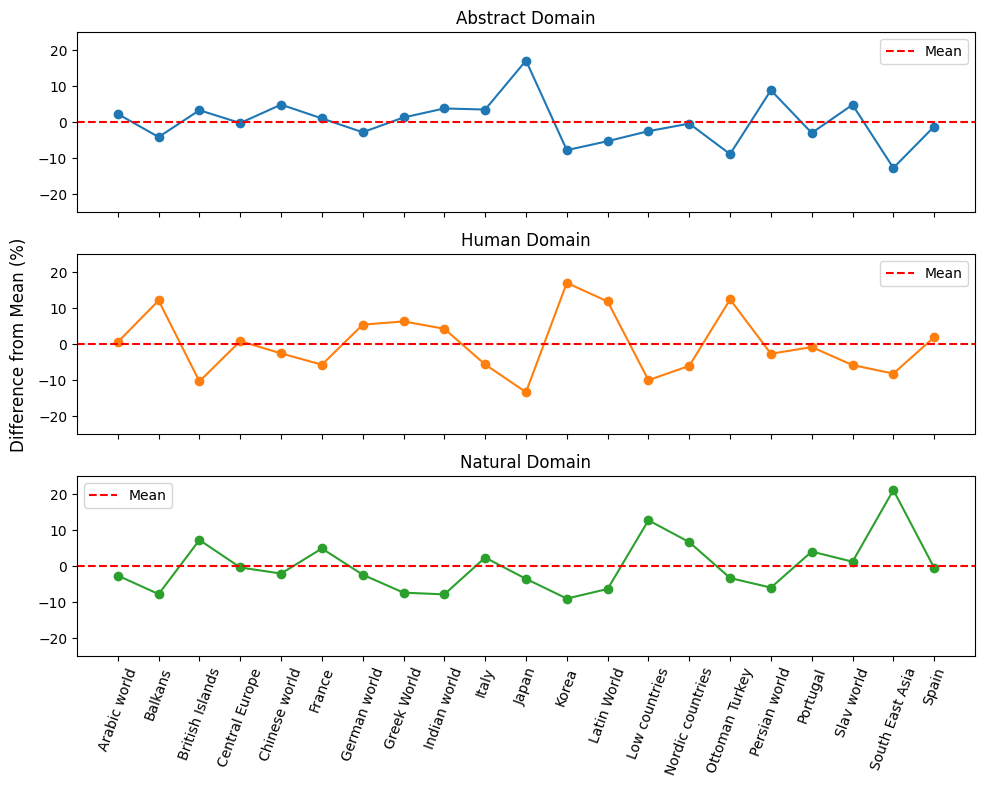

In [76]:
# Calculate the mean percentage for each domain
mean_percentages = df_country.groupby('domain')['percent'].mean()
mean_percentages.reset_index()['percent'].sum()

import matplotlib.pyplot as plt

# Create a new column for the difference from the mean
df_country['difference_from_mean'] = df_country.apply(lambda row: row['percent'] - mean_percentages[row['domain']], axis=1)


# Create a single graph with three subplots stacked on top of each other
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjust the height (7) as needed

# List of unique domains
domains = df_country['domain'].unique()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose nicer colors

for i, domain in enumerate(domains):
    domain_data = df_country[df_country['domain'] == domain]
    
    axs[i].plot(domain_data['region_name'], domain_data['difference_from_mean'], marker='o', linestyle='-', color=colors[i])
    axs[i].axhline(y=0, color='r', linestyle='--', label='Mean')
    #axs[i].set_ylabel('Difference from Mean (%)')
    axs[i].set_title(f'{domain}')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].legend(loc='upper right')
    
    # Set the y-axis limits to -100 to 100
    axs[i].set_ylim(-25, 25)
    
    axs[i].legend()
    axs[i].grid(False)

# Add a unique ylabel
fig.supylabel('Difference from Mean (%)')

plt.tight_layout()
plt.xticks(rotation=70)
plt.show()